# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from transformers import BertTokenizer

f:\Data Science and ML\End To End ML\Youtube Comment Analytics and  Summarizer\YouTube-Comments-Analytics-and-Summarizer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Importing Dataset

In [2]:
df = pd.read_csv("../dataset/archive/train.csv")
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [21]:
df.groupby("class").agg(
    hate_speech_count=("hate_speech_count","sum"),
    offensive_language_count=("offensive_language_count","sum"),
    neither_count=("neither_count","sum"),
)

,hate_speech_count,offensive_language_count,neither_count
class,,,
0,3227,1081,137
1,3463,57638,1629
2,262,1100,11846


***class 0 = hate tweet
class 1 = offensive tweet
class 2 = neutral tweet***

In [17]:
df["class"].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

# Data Splitting

In [3]:
X = df["tweet"].values
y = df["class"].values
# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)


In [23]:
len(np.unique(y))

3

# Tokenization

In [4]:
tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

f:\Data Science and ML\End To End ML\Youtube Comment Analytics and  Summarizer\YouTube-Comments-Analytics-and-Summarizer\.venv\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
sequences = [sequence for sequence in X]
model_inputs = tokenizer(sequences,padding=True,return_tensors="tf")

In [6]:
model_inputs

{'input_ids': <tf.Tensor: shape=(24783, 484), dtype=int32, numpy=
array([[ 101,  106,  106, ...,    0,    0,    0],
       [ 101,  106,  106, ...,    0,    0,    0],
       [ 101,  106,  106, ...,    0,    0,    0],
       ...,
       [ 101, 1685,  171, ...,    0,    0,    0],
       [ 101, 1128, 1358, ...,    0,    0,    0],
       [ 101,  199,  199, ...,    0,    0,    0]])>, 'token_type_ids': <tf.Tensor: shape=(24783, 484), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])>, 'attention_mask': <tf.Tensor: shape=(24783, 484), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])>}

# Prepraing Dataset

In [12]:
dataset = tf.data.Dataset.from_tensor_slices((model_inputs["input_ids"],y))

dataset = dataset.cache()
dataset = dataset.shuffle(20000)

dataset = dataset.batch(16)
dataset = dataset.prefetch(8)


In [13]:
train = dataset.take(int(len(dataset)*0.7))
validation = dataset.skip(int(len(dataset)*0.7)).take((int(len(dataset)*0.2)))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))


# Model Building

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional

In [32]:
model = Sequential(name="text-classifier")
model.add(Embedding(len(tokenizer.get_vocab()),32))
model.add(Bidirectional(LSTM(32,activation="tanh")))
model.add(Dense(128,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(16,activation="relu"))
model.add(Dense(len(np.unique(y)),activation="softmax"))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [48]:
history = model.fit(train,epochs=10,batch_size=16,validation_data=validation)

Epoch 1/3


1084/1084 ━━━━━━━━━━━━━━━━━━━━ 245s 226ms/step - accuracy: 0.9564 - loss: 0.1364 - val_accuracy: 0.9693 - val_loss: 0.1034
Epoch 2/3
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 292s 269ms/step - accuracy: 0.9665 - loss: 0.1065 - val_accuracy: 0.9737 - val_loss: 0.0846
Epoch 3/3
1084/1084 ━━━━━━━━━━━━━━━━━━━━ 264s 244ms/step - accuracy: 0.9744 - loss: 0.0826 - val_accuracy: 0.9759 - val_loss: 0.0718


In [41]:
history.history["accuracy"]

[0.9016374349594116,
 0.9189921617507935,
 0.9320226311683655,
 0.9452836513519287]

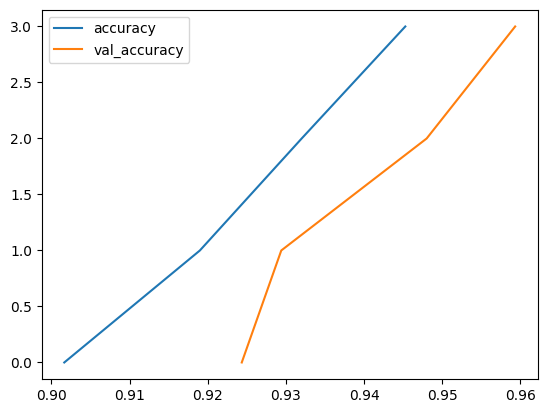

In [47]:
plt.plot(history.history["accuracy"],history.epoch,label="accuracy")
plt.plot(history.history["val_accuracy"],history.epoch,label="val_accuracy")
plt.legend()

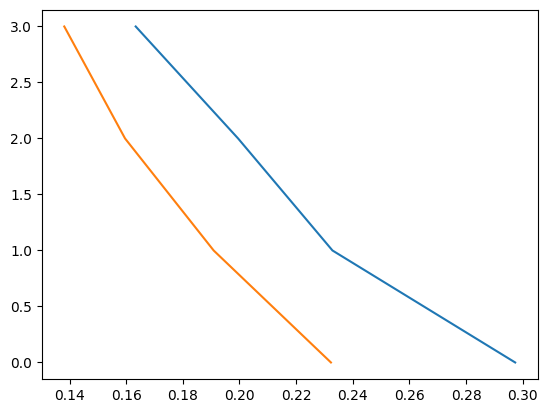

In [46]:
plt.plot(history.history["loss"],history.epoch)
plt.plot(history.history["val_loss"],history.epoch)


In [62]:
predicted_class = {
    0 : "hate",
    1: "offensive",
    2: "neutral",
}

text = "This is a random tweet."

# Preprocess the text using the tokenizer
tokenized_text = tokenizer(text, padding=True, return_tensors="tf")

# Get model predictions
predictions = model.predict(tokenized_text["input_ids"])

# Convert predictions to class labels
prediciton = np.argmax(predictions)

print("Predicted class:", predicted_class[prediciton])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Predicted class: neutral
